# Gaussian Discriminant Analysis for MNIST Handwritten Digits

This is a project I first did as part of a class assignment that I went above and beyond with. 

We are going to use QDA and LDA to classify handwritten digits from the MNIST dataset.

In [4]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.io
import collections
import skimage.measure
import skimage.transform
import skimage.filters
import skimage.morphology
import skimage.feature
import math
from PIL import Image
import sklearn.preprocessing
import sklearn.discriminant_analysis

Below is a class I made that handles both LDA and QDA, the fit function actually fits both LDA and QDA, in a real application you would want to choose one or the other to improve performance, but since in this instance I wanted to use both it works.

In [19]:
class Gaussian_classifier():
    cov_matrices = {}
    inv_matrices = {}
    det = {}
    avg_cov_matrix = None
    cov_inverse = None
    labels = None
    mean_matrices = {}
    C = 1.0

    def __init__(self, labels, C=1.0):
        self.C = C
        self.labels = labels

    #Fits the gaussians to the given data after processing it, calculates
    #matrices for LDA and QDA
    def fit(self, data):
        sorted_data = collections.defaultdict(list)
        for elem in data:
            index = elem[-1]
            elem = self.preProcess(elem[:-1])
            sorted_data[index].append(elem)
        for index in self.labels:
            sorted_data[index] = np.asarray(sorted_data[index])
            self.mean_matrices[index] = np.empty(len(sorted_data[index][0]))
            self.cov_matrices[index] = np.cov(sorted_data[index].T)
            for k in range(len(sorted_data[index][0])):
                self.mean_matrices[index][k] = np.mean(sorted_data[index][:, k])
        self.avg_cov_matrix = sum(list(self.cov_matrices.values())) / len(self.labels)
        if np.linalg.det(self.avg_cov_matrix) == 0:
            self.avg_cov_matrix = self.avg_cov_matrix + + self.C * np.identity(self.avg_cov_matrix.shape[0])
            self.cov_inverse = np.linalg.inv(self.avg_cov_matrix)
        for index in self.labels:
            #if np.linalg.det(self.cov_matrices[index]) == 0:
            self.cov_matrices[index] = self.cov_matrices[index] + self.C * np.identity(self.cov_matrices[index].shape[0])
            self.inv_matrices[index] = np.linalg.inv(self.cov_matrices[index])
            self.det[index] = np.linalg.slogdet(self.cov_matrices[index])

    #Classifies a given point using the LDA model
    def LDA_classify(self, point):
        point = self.preProcess(point)
        def linear_fn(x, mean, cov):
            return np.dot(np.dot(mean.T, cov), x) - 0.5 * np.dot(np.dot(mean.T, cov), mean) + np.log(1.0 / 10.0)

        return max(self.labels, key=lambda x: linear_fn(point, self.mean_matrices[x], self.cov_inverse))

    #Classifies a given point using QDA model
    def QDA_classify(self, point):
        point = self.preProcess(point)

        def descriminant_fn(x, mean, incov, det):
            det = np.real(det)[0]
            return (-0.5) * (x - mean).T.dot(incov).dot(x - mean) - 0.5 * det + np.log(1.0 / 10.0)

        return max(self.labels,
                   key=lambda x: descriminant_fn(point, self.mean_matrices[x], self.inv_matrices[x], self.det[x]))

    # Takes in a mnist image and 'deskews' it to try to improve performance. Probably can be improved, inspired by
    # opencv article and implemented by messing around with moments and equations found in wikipedia. Seems to work.
    def deskew(self, img):
        img = np.array(img, dtype='uint8')
        img = img.reshape((28, 28))
        moments = skimage.measure.moments(img, order=2)
        centroid = [moments[0, 1] / moments[0, 0], moments[1, 0] / moments[0, 0]]
        center_moments = skimage.measure.moments_central(img, centroid[0], centroid[1], 2)

        u02 = center_moments[0, 2] / center_moments[0, 0]
        u11 = center_moments[1, 1] / center_moments[0, 0]

        skew = u11 / u02
        transform = skimage.transform.AffineTransform(np.asarray([[1, skew, -.5 * 28 * skew], [0, 1, 0], [0, 0, 1]]))
        newimage = skimage.transform.warp(img, transform)
        return newimage

    #Catch all, applied all preprocessing techniques in one function.
    def preProcess(self, point):
        deskewed = self.deskew(point)
        processed = deskewed.reshape((784, ))
        processed = processed.reshape((28, 28))
        Axx, Axy, Ayy = skimage.feature.structure_tensor(processed)
        struct = np.asarray([[Axx, Axy], [Axy, Ayy]]).ravel()
        return struct

    #Returns accuracy of LDA model over given data, assumes label is last element
    def scoreLDA(self, data):
        correct = 0.0
        for elem in data:
            label = elem[-1]
            guess = self.LDA_classify(elem[:-1])
            if label == guess:
                correct += 1.0
        return correct / len(data)

    #Returns accuracy of QDA model over given data, assumes label is last element
    def scoreQDA(self, data):
        correct = 0.0
        for elem in data:
            label = elem[-1]
            guess = self.QDA_classify(elem[:-1])
            if label == guess:
                correct += 1.0
        return correct / len(data)

Let's load our data and seperate it into training and validation sets, making sure to randomize order first.

In [6]:
mnist_raw_data = scipy.io.loadmat('train.mat')['trainX']
np.random.shuffle(mnist_raw_data)
validation_set = mnist_raw_data[:10000]
training_set = mnist_raw_data[10000:]

Now let's run our classifier on the MNIST data with no preprocessing, here I will comment out all the lines in the preprocessing function and simply have it return the original point, this will serve as a baseline for the accuracy of the model.

In [19]:
#Create an instance of the Gaussian Classifier, passing in the labels.
classifier = Gaussian_classifier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#Fit the data to our set
classifier.fit(training_set)
print("LDA Score: ", classifier.scoreLDA(validation_set))
print("QDA Score: ", classifier.scoreQDA(validation_set))

LDA Score:  0.8636
QDA Score:  0.8541


So with no preprocessing we see that LDA slightly outperforms QDA by ~1% additional accuracy, however both are in the mid 80s, so there is a lot of room for improvement.

The first step we might try is normalizing the data, I will use StandardScaler from sklearn library to do this. Let's re-run our classifier and see if this changes anything (Spoiler, it won't. Using Normalized data for LDA and QDA is mathematically equivalent to the original data).

In [28]:
#Call the Scaler and transform the data.
Scaler = sklearn.preprocessing.StandardScaler()
Scaler.fit_transform(training_set)
Scaler.transform(validation_set)

#Create an instance of the Gaussian Classifier, passing in the labels.
classifier = Gaussian_classifier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#Fit the data to our set
classifier.fit(training_set)
print("LDA Score: ", classifier.scoreLDA(validation_set))
print("QDA Score: ", classifier.scoreQDA(validation_set))

C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


LDA Score:  0.8636
QDA Score:  0.8541


So that doesn't help, so what will? Let's take a look at some of the data to see if we can identify any issues to address (MNIST datapoints are pictures, so why not look at them?)

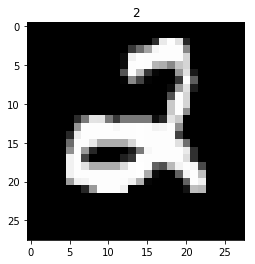

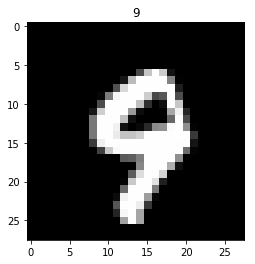

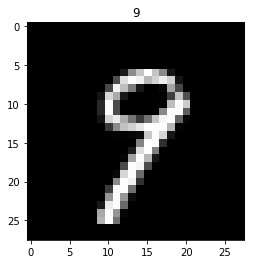

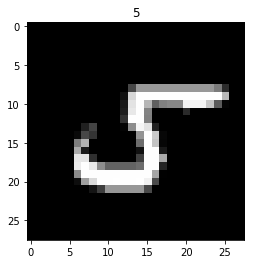

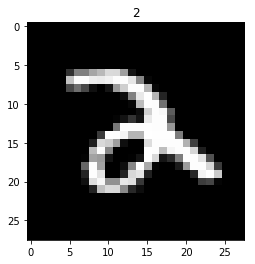

In [32]:
for i in range(5):
    pixels = np.array(mnist_raw_data[i+15][:-1], dtype='uint8')
    pixels = pixels.reshape((28, 28))
    label = mnist_raw_data[i+15][-1]
    plt.title(label)
    plt.imshow(pixels, cmap='gray')
    plt.show()

Notice how all of the images are skewed in some way, a great example is the first 2 compared to the last 2, they are both the same number, but look very different since they are skewed in opposite directions. In our model, we want our data to be as homogenous as possible, so let's try to deskew the images so that they are all centered and straight. I will copy the deskewing function I wrote for this, based off OpenCV forums and wikipedia pages about computer vision, and see how it changes the images.

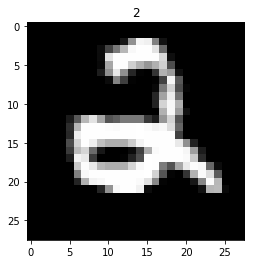

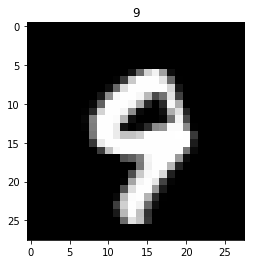

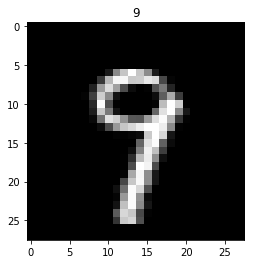

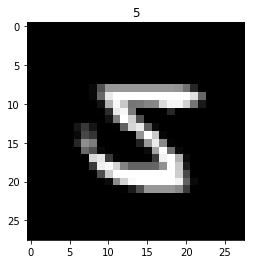

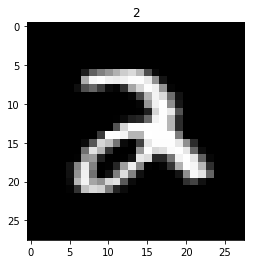

In [33]:
def deskew(img):
        img = np.array(img, dtype='uint8')
        img = img.reshape((28, 28))
        moments = skimage.measure.moments(img, order=2)
        centroid = [moments[0, 1] / moments[0, 0], moments[1, 0] / moments[0, 0]]
        center_moments = skimage.measure.moments_central(img, centroid[0], centroid[1], 2)

        u02 = center_moments[0, 2] / center_moments[0, 0]
        u11 = center_moments[1, 1] / center_moments[0, 0]

        skew = u11 / u02
        transform = skimage.transform.AffineTransform(np.asarray([[1, skew, -.5 * 28 * skew], [0, 1, 0], [0, 0, 1]]))
        newimage = skimage.transform.warp(img, transform)
        return newimage
    
for i in range(5):
    pixels = np.array(mnist_raw_data[i+15][:-1], dtype='uint8')
    pixels = deskew(pixels)
    label = mnist_raw_data[i+15][-1]
    plt.title(label)
    plt.imshow(pixels, cmap='gray')
    plt.show()

Pretty good! the numbers are noticably straighter, and the 2's in particular look much more similar now. Let's re-run our classifiers with deskewing enables to see if it makes a difference.

In [35]:
#Create an instance of the Gaussian Classifier, passing in the labels.
classifier = Gaussian_classifier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#Fit the data to our set
classifier.fit(training_set)
print("LDA Score: ", classifier.scoreLDA(validation_set))
print("QDA Score: ", classifier.scoreQDA(validation_set))

LDA Score:  0.8898
QDA Score:  0.9592


Wow! Deskewing the data improved our LDA accuracy by ~2.5% and our QDA accuracy by a massive ~10%.

The last technique I learned about by reading papers in Histogram of Oriented Gradients, this is a fairly complicated computer vision descriptor that aims to describe shape through gradient intesities in localised portions of the image, when I applied this to the data, there was no change in accuracy, but it led me to look into something similar, the structure tensor. Like HOG, the structure tensor describes the direction of gradients in an image, and also describes how coherent the directions are. Let's calculate the structure tensor of our deskewed data and run our models on that instead.

In [20]:
#Create an instance of the Gaussian Classifier, passing in the labels.
classifier = Gaussian_classifier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#Fit the data to our set
classifier.fit(training_set)
print("LDA Score: ", classifier.scoreLDA(validation_set))
print("QDA Score: ", classifier.scoreQDA(validation_set))

LDA Score:  0.9646
QDA Score:  0.979


Pretty good! We increased our QDA score by ~2% and our LDA score by ~7.5%! So we just increased validation accuracy from the measly ~86% we had with no pre-processing to almost 98% through only two steps, deskewing and calculating the structure array. 

It's worth noting that while deskewing is fairly cheap computationally, calculating the structure tensor, (or similar things like HOG) is not. Our data started out as a length 784 vector (corresponding to the 28x28 image) and the structure tensor has dimensions (2, 2, 28, 28). So not only does computing the tensor take time, but the increased dimensionality on the data results in much longer training and prediction times. If our data was larger, computing the structure tensor might not be feasible if using the full vector. In that case we could use PCA or other dimensionality reduction techniques to improve training and prediction times at low cost to accuracy (sometimes PCA can actually help accuracy by removing noise!). 

# Lessons for next project